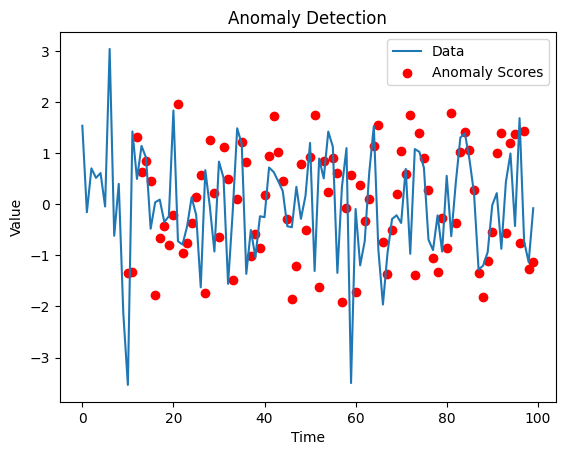

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def moving_z_score(history_window, prediction_window, window_size):
    """
    Apply Moving Z-Score anomaly detection algorithm to a history window.

    Parameters:
    - history_window: List of historical data points.
    - prediction_window: List of prediction data points.
    - window_size: Size of the moving window for calculating Z-Score.

    Returns:
    - Anomaly score for the prediction window.
    """
    z_scores = []
    for i in range(len(history_window)):
        start_index = max(0, i - window_size + 1)
        window_data = history_window[start_index:i+1]
        mean = np.mean(window_data)
        std_dev = np.std(window_data)
        if std_dev == 0:
            z_score = 0  # Avoid division by zero
        else:
            z_score = (history_window[i] - mean) / std_dev
        z_scores.append(z_score)
    anomaly_score = z_scores[-1]  # Using the last Z-Score as the anomaly score
    return anomaly_score

def time_series_segmentation(data, history_window_size, prediction_window_size, anomaly_algorithm='moving_z_score', window_size=5):
    """
    Segment time-series data into overlapping history and prediction windows, and apply anomaly detection algorithm.

    Parameters:
    - data: The univariate time-series data (1D array).
    - history_window_size: The size of the history window (int).
    - prediction_window_size: The size of the prediction window (int).
    - anomaly_algorithm: The anomaly detection algorithm to apply (str). Default is 'moving_z_score'.
    - window_size: Size of the moving window for anomaly detection algorithms (int). Default is 5.

    Returns:
    - history_windows: List of history windows.
    - prediction_windows: List of prediction windows.
    - anomaly_scores: List of anomaly scores for each prediction window.
    """
    history_windows = []
    prediction_windows = []
    anomaly_scores = []

    # Apply sliding window approach
    for i in range(len(data) - history_window_size - prediction_window_size + 1):
        history_window = data[i:i + history_window_size]
        prediction_window = data[i + history_window_size:i + history_window_size + prediction_window_size]

        # Apply anomaly detection algorithm
        if anomaly_algorithm == 'moving_z_score':
            anomaly_score = moving_z_score(history_window, prediction_window, window_size)
        else:
            raise ValueError("Invalid anomaly detection algorithm. Please choose 'moving_z_score'.")

        history_windows.append(history_window)
        prediction_windows.append(prediction_window)
        anomaly_scores.append(anomaly_score)

    return history_windows, prediction_windows, anomaly_scores

# Example usage
# Example data
data = np.random.randn(100)

# Specify the size of the history window and prediction window
history_window_size = 10
prediction_window_size = 1

# Perform time-series segmentation with anomaly detection
history_windows, prediction_windows, anomaly_scores = time_series_segmentation(data, history_window_size, prediction_window_size)

# Visualize the anomaly scores
plt.plot(data, label='Data')
plt.scatter(range(history_window_size, len(data)), anomaly_scores, color='red', label='Anomaly Scores')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Anomaly Detection')
plt.legend()
plt.show()


In [ ]:
#/content/ambient_temperature_system_failure.csv

# libraries
#%matplotlib notebook

import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [ ]:
df = pd.read_csv("/content/ambient_temperature_system_failure.csv")
print(df.info())
print(df['timestamp'].head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB
None
0    2013-07-04 00:00:00
1    2013-07-04 01:00:00
2    2013-07-04 02:00:00
3    2013-07-04 03:00:00
4    2013-07-04 04:00:00
5    2013-07-04 05:00:00
6    2013-07-04 06:00:00
7    2013-07-04 07:00:00
8    2013-07-04 08:00:00
9    2013-07-04 09:00:00
Name: timestamp, dtype: object


In [ ]:
# the hours and if it's night or day (7:00-22:00)
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01
# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

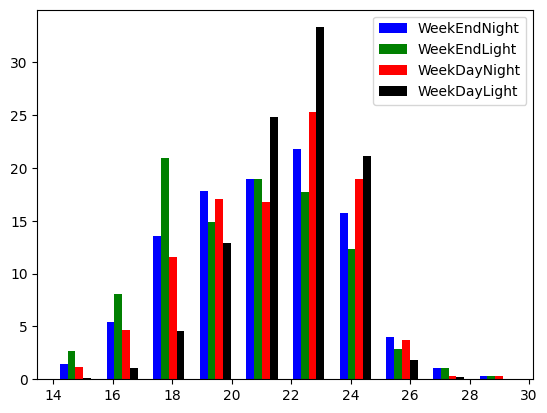

In [ ]:
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

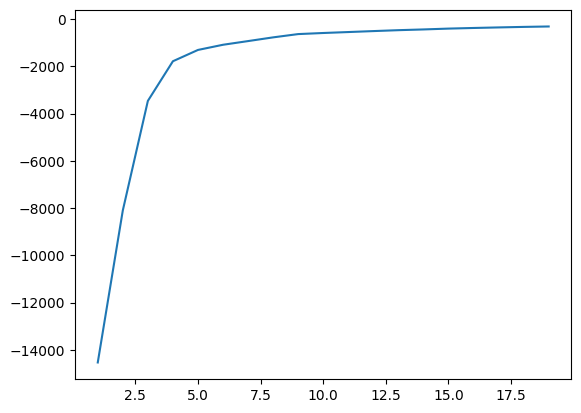

In [ ]:
# Take useful feature and standardize them
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [ ]:
df['cluster'] = kmeans[14].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()


ValueError: X has 5 features, but KMeans is expecting 2 features as input.

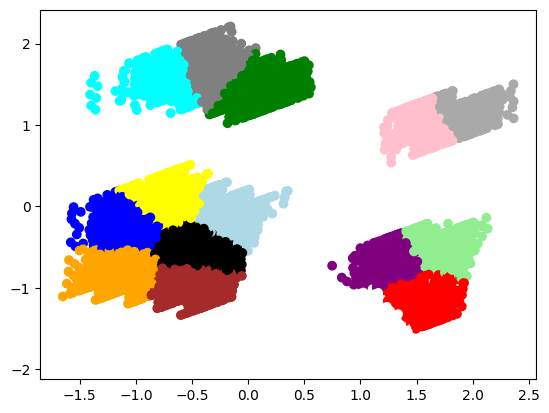

In [ ]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [ ]:
print(df.columns)  # To check column names
print(df.index)    # To check index labels


Index(['timestamp', 'value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay',
       'time_epoch', 'categories', 'cluster', 'principal_feature1',
       'principal_feature2'],
      dtype='object')
RangeIndex(start=0, stop=7267, step=1)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


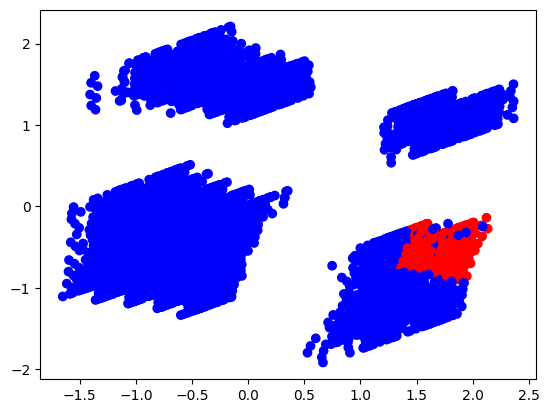

Silhouette Score: 0.17268270489048537


In [ ]:
from sklearn.cluster import KMeans

# Fit KMeans clustering model to your data
kmeans_model = KMeans(n_clusters=20)
kmeans_model.fit(data)

# Calculate distances between each point and its nearest centroid
nearest_centroid_distances, _ = pairwise_distances_argmin_min(data, kmeans_model.cluster_centers_)

# Sort the distances in descending order
nearest_centroid_distances_sorted = sorted(nearest_centroid_distances, reverse=True)

# Determine the threshold for anomalies
number_of_outliers = int(outliers_fraction * len(nearest_centroid_distances_sorted))
threshold = nearest_centroid_distances_sorted[number_of_outliers]

# Mark anomalies based on the threshold
df['anomaly21'] = (nearest_centroid_distances >= threshold).astype(int)
# visualisation of anomaly with cluster view
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: colors[x]))
plt.show()
from sklearn.metrics import silhouette_score

# Assuming you have already fitted the KMeans model and added cluster labels to the dataframe

# Calculate the silhouette score
silhouette_avg = silhouette_score(data, df['cluster'])

print("Silhouette Score:", silhouette_avg)


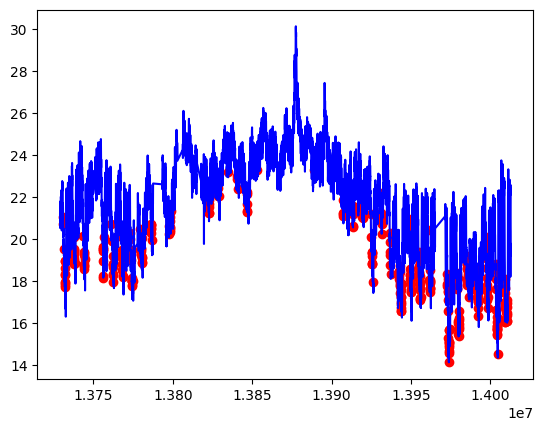

In [ ]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

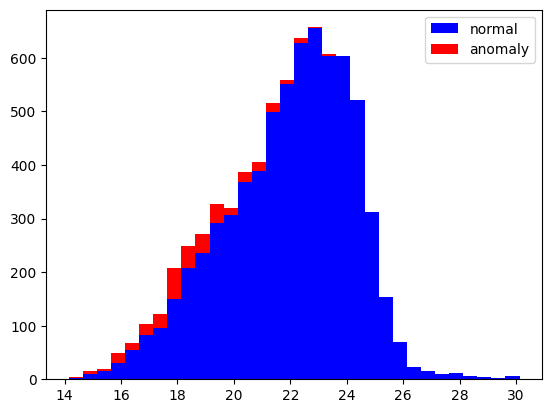

In [ ]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly21'] == 0, 'value']
b = df.loc[df['anomaly21'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

<Axes: >

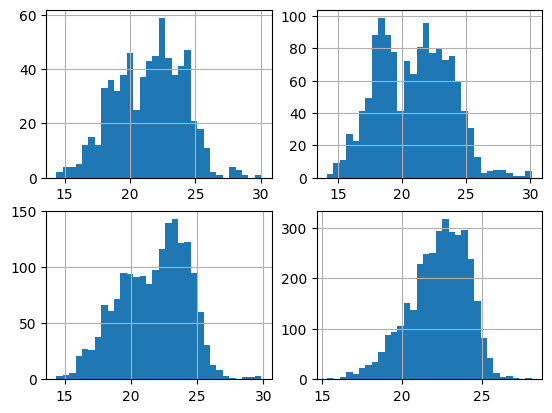

In [ ]:
# creation of 4 differents data set based on categories defined before
df_class0 = df.loc[df['categories'] == 0, 'value']
df_class1 = df.loc[df['categories'] == 1, 'value']
df_class2 = df.loc[df['categories'] == 2, 'value']
df_class3 = df.loc[df['categories'] == 3, 'value']
# plot the temperature repartition by categories
fig, axs = plt.subplots(2,2)
df_class0.hist(ax=axs[0,0],bins=32)
df_class1.hist(ax=axs[0,1],bins=32)
df_class2.hist(ax=axs[1,0],bins=32)
df_class3.hist(ax=axs[1,1],bins=32)

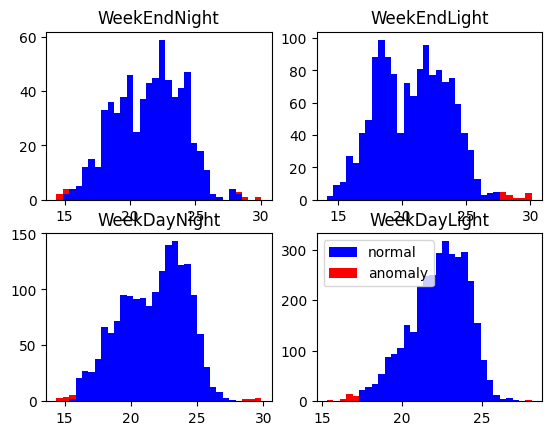

In [ ]:
envelope =  EllipticEnvelope(contamination=outliers_fraction)

# For each category
for df_class in [df_class0, df_class1, df_class2, df_class3]:
    X_train = df_class['value'].values.reshape(-1, 1)  # Reshape the data
    envelope.fit(X_train)
    df_class['deviation'] = envelope.decision_function(X_train)
    df_class['anomaly'] = envelope.predict(X_train)

# Plot the temperature repartition by categories with anomalies
fig, axs = plt.subplots(2, 2)
for i, (df_class, title) in enumerate(zip([df_class0, df_class1, df_class2, df_class3], ["WeekEndNight", "WeekEndLight", "WeekDayNight", "WeekDayLight"])):
    a = df_class.loc[df_class['anomaly'] == 1, 'value']
    b = df_class.loc[df_class['anomaly'] == -1, 'value']
    axs[i//2, i%2].hist([a, b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
    axs[i//2, i%2].set_title(title)
plt.legend()
plt.show()


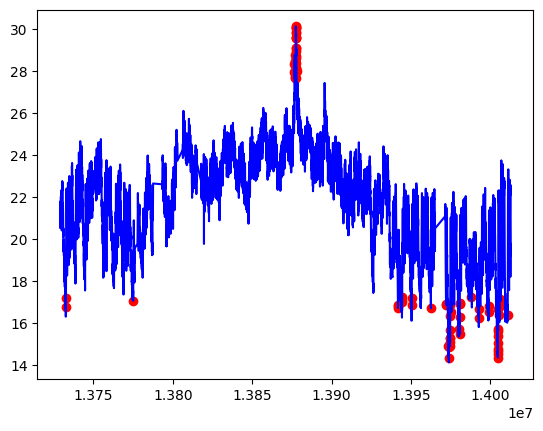

In [ ]:
# add the data to the main
df_class = pd.concat([df_class0, df_class1, df_class2, df_class3])
df['anomaly22'] = df_class['anomaly']
df['anomaly22'] = np.array(df['anomaly22'] == -1).astype(int)
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly22'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

0    7194
1      73
Name: anomaly25, dtype: int64


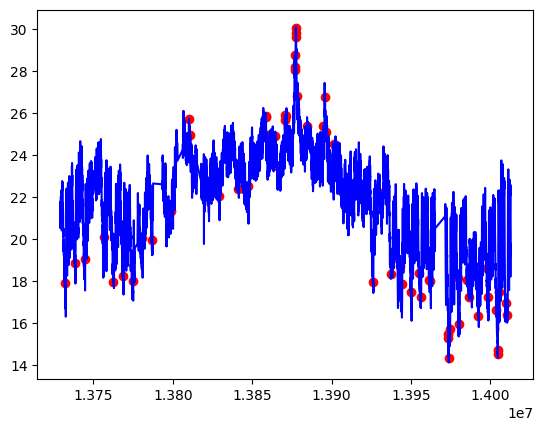

In [ ]:
# Take useful feature and standardize them
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main
df['anomaly25'] = pd.Series(model.predict(data))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly25'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

71.24243270828815


<Axes: xlabel='timestamp'>

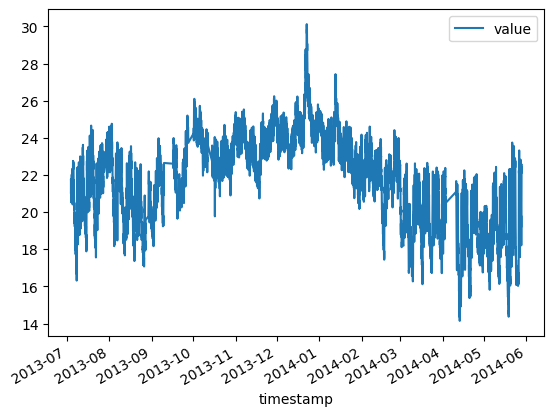

In [ ]:
# check the temperature mean
print(df['value'].mean())
# change the type of timestamp column for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])
# change fahrenheit to °C (temperature mean= 71 -> fahrenheit)
df['value'] = (df['value'] - 32) * 5/9
# plot the data
df.plot(x='timestamp', y='value')

In [ ]:
from sklearn.metrics import silhouette_score

# Silhouette score
silhouette = silhouette_score(data, df['anomaly25'])

print("Silhouette Score:", silhouette)


Silhouette Score: 0.26715783524811043


In [ ]:

from sklearn.mixture import GaussianMixture

# Now you can use GaussianMixture
gmm = GaussianMixture(n_components=3)
gmm.fit(data)

# K-means clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(data)

# Hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=3)
hierarchical.fit(data)

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(data)

# Gaussian Mixture Models
gmm = GaussianMixture(n_components=3)
gmm.fit(data)




/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


GaussianMixture(n_components=3)

In [ ]:
# Experiment with different values of K for K-means
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    # Evaluate clustering performance

# Experiment with different values of epsilon and min_samples for DBSCAN
for epsilon in [0.1, 0.2, 0.5]:
    for min_samples in [3, 5, 7]:
        dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
        dbscan.fit(data)
        # Evaluate clustering performance


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)


In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Evaluate silhouette score for K-means
silhouette_kmeans = silhouette_score(data, kmeans.labels_)
print("Silhouette Score for K-means:", silhouette_kmeans)

# Evaluate Davies–Bouldin index for DBSCAN
db_index = davies_bouldin_score(data, dbscan.labels_)
print("Davies–Bouldin Index for DBSCAN:", db_index)

# Evaluate Calinski–Harabasz index for Gaussian Mixture Models
ch_index = calinski_harabasz_score(data, gmm.predict(data))
print("Calinski–Harabasz Index for Gaussian Mixture Models:", ch_index)


Silhouette Score for K-means: 0.33427684361750487
Davies–Bouldin Index for DBSCAN: 2.758491051697568
Calinski–Harabasz Index for Gaussian Mixture Models: 4289.742302597221


             value
count  1882.000000
mean      0.039578
std       0.056545
min       0.000000
25%       0.000000
50%       0.000000
75%       0.072769
max       0.895012


<ipython-input-15-22f5d488ad20>:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hourly_data = data.groupby('hourly_interval').mean().reset_index()


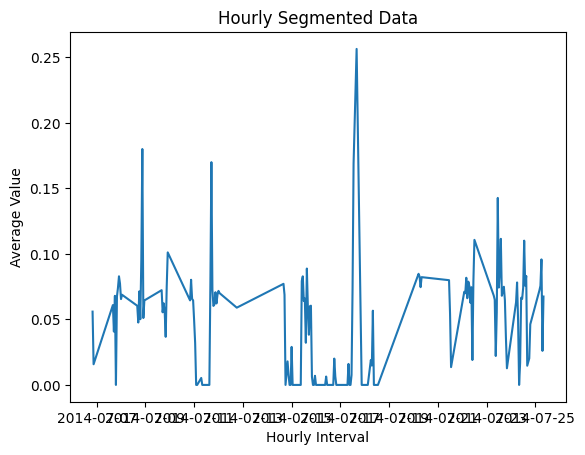

In [ ]:
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/rogue_agent_key_hold.csv')


# Display summary statistics
summary_stats = data.describe()
print(summary_stats)

# Convert timestamp column to datetime format
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Round timestamp to the nearest hour and create hourly intervals
data['hourly_interval'] = data['timestamp'].dt.floor('H')

# Group data by hourly intervals and aggregate values
hourly_data = data.groupby('hourly_interval').mean().reset_index()

# Plot hourly data
plt.plot(hourly_data['hourly_interval'], hourly_data['value'])
plt.xlabel('Hourly Interval')
plt.ylabel('Average Value')
plt.title('Hourly Segmented Data')
plt.show()


<ipython-input-3-4bd2ca2fa3de>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  weekly_data = data.groupby('weekly_interval').mean().reset_index()


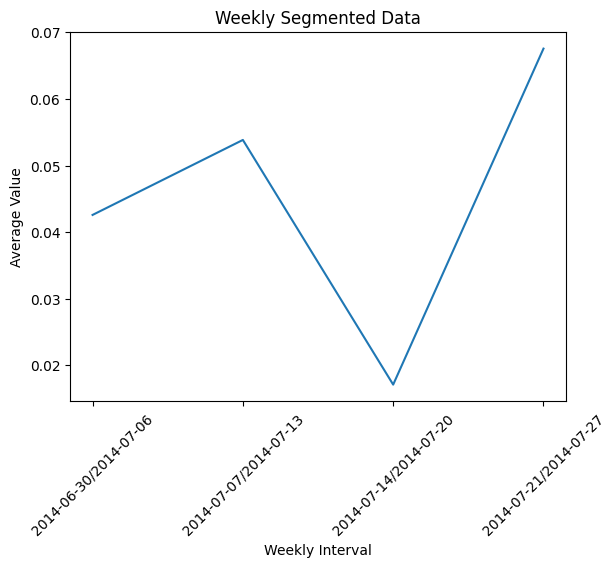

In [ ]:


# Round timestamp to the nearest week and create weekly intervals
data['weekly_interval'] = data['timestamp'].dt.to_period('W')

# Group data by weekly intervals and aggregate values
weekly_data = data.groupby('weekly_interval').mean().reset_index()

# Plot weekly data
plt.plot(weekly_data['weekly_interval'].astype(str), weekly_data['value'])
plt.xlabel('Weekly Interval')
plt.ylabel('Average Value')
plt.title('Weekly Segmented Data')
plt.xticks(rotation=45)
plt.show()


<ipython-input-4-433996797b76>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_data = data.groupby('daily_interval').mean().reset_index()


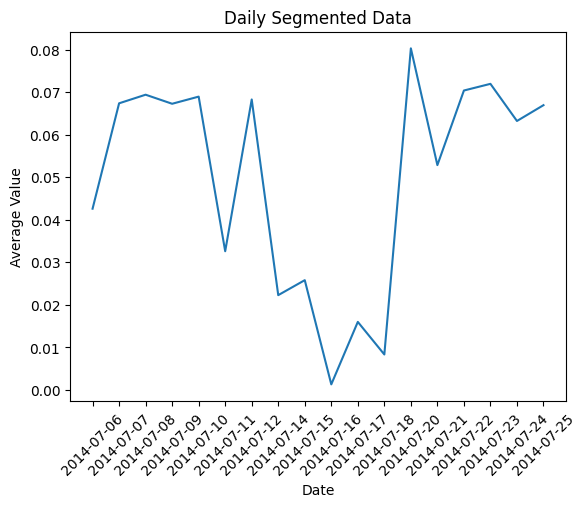

In [ ]:


# Round timestamp to the nearest day and create daily intervals
data['daily_interval'] = data['timestamp'].dt.to_period('D')

# Group data by daily intervals and aggregate values
daily_data = data.groupby('daily_interval').mean().reset_index()

# Plot daily data
plt.plot(daily_data['daily_interval'].astype(str), daily_data['value'])
plt.xlabel('Date')
plt.ylabel('Average Value')
plt.title('Daily Segmented Data')
plt.xticks(rotation=45)
plt.show()


<ipython-input-7-b990490de9ca>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  interval_data = data.groupby('3hour_interval').mean().reset_index()


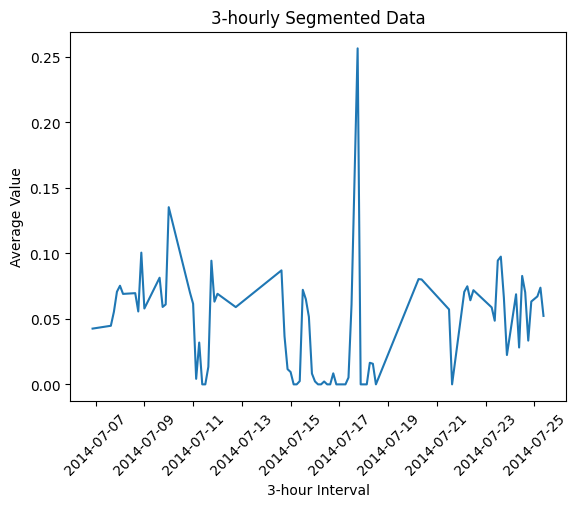

In [ ]:

# Round timestamp to the nearest 3-hour interval and create 3-hour intervals
data['3hour_interval'] = data['timestamp'].dt.round('3H')

# Group data by 3-hour intervals and aggregate values
interval_data = data.groupby('3hour_interval').mean().reset_index()

# Plot 3-hourly data
plt.plot(interval_data['3hour_interval'], interval_data['value'])
plt.xlabel('3-hour Interval')
plt.ylabel('Average Value')
plt.title('3-hourly Segmented Data')
plt.xticks(rotation=45)
plt.show()


<ipython-input-8-69c8008da58c>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  interval_data = data.resample('90T').mean().reset_index()


(array([16258., 16260., 16262., 16264., 16266., 16268., 16270., 16272.,
        16274., 16276.]),
 [Text(16258.0, 0, '2014-07-07'),
  Text(16260.0, 0, '2014-07-09'),
  Text(16262.0, 0, '2014-07-11'),
  Text(16264.0, 0, '2014-07-13'),
  Text(16266.0, 0, '2014-07-15'),
  Text(16268.0, 0, '2014-07-17'),
  Text(16270.0, 0, '2014-07-19'),
  Text(16272.0, 0, '2014-07-21'),
  Text(16274.0, 0, '2014-07-23'),
  Text(16276.0, 0, '2014-07-25')])

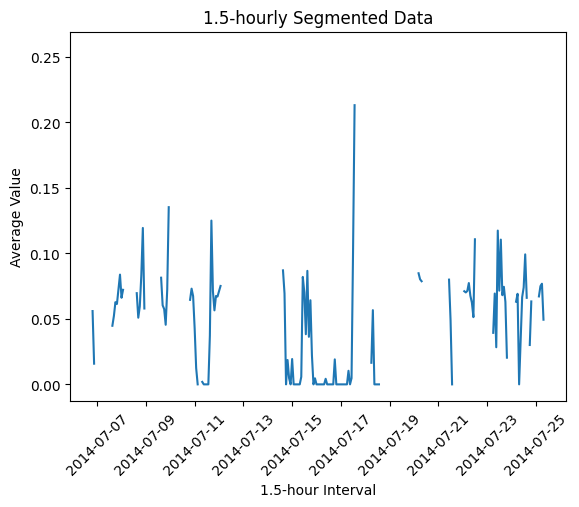

In [ ]:

# Set timestamp column as index
data.set_index('timestamp', inplace=True)

# Resample the data to 1.5-hour intervals and aggregate values
interval_data = data.resample('90T').mean().reset_index()

# Plot 1.5-hourly data
plt.plot(interval_data['timestamp'], interval_data['value'])
plt.xlabel('1.5-hour Interval')
plt.ylabel('Average Value')
plt.title('1.5-hourly Segmented Data')
plt.xticks(rotation=45)

                        value     hourly_interval        weekly_interval  \
timestamp                                                                  
2014-07-06 20:10:00  0.064535 2014-07-06 20:00:00  2014-06-30/2014-07-06   
2014-07-06 20:15:00  0.064295 2014-07-06 20:00:00  2014-06-30/2014-07-06   
2014-07-06 20:20:00  0.063880 2014-07-06 20:00:00  2014-06-30/2014-07-06   
2014-07-06 20:25:00  0.065692 2014-07-06 20:00:00  2014-06-30/2014-07-06   
2014-07-06 20:35:00  0.056301 2014-07-06 20:00:00  2014-06-30/2014-07-06   

                    daily_interval      3hour_interval  
timestamp                                               
2014-07-06 20:10:00     2014-07-06 2014-07-06 21:00:00  
2014-07-06 20:15:00     2014-07-06 2014-07-06 21:00:00  
2014-07-06 20:20:00     2014-07-06 2014-07-06 21:00:00  
2014-07-06 20:25:00     2014-07-06 2014-07-06 21:00:00  
2014-07-06 20:35:00     2014-07-06 2014-07-06 21:00:00  


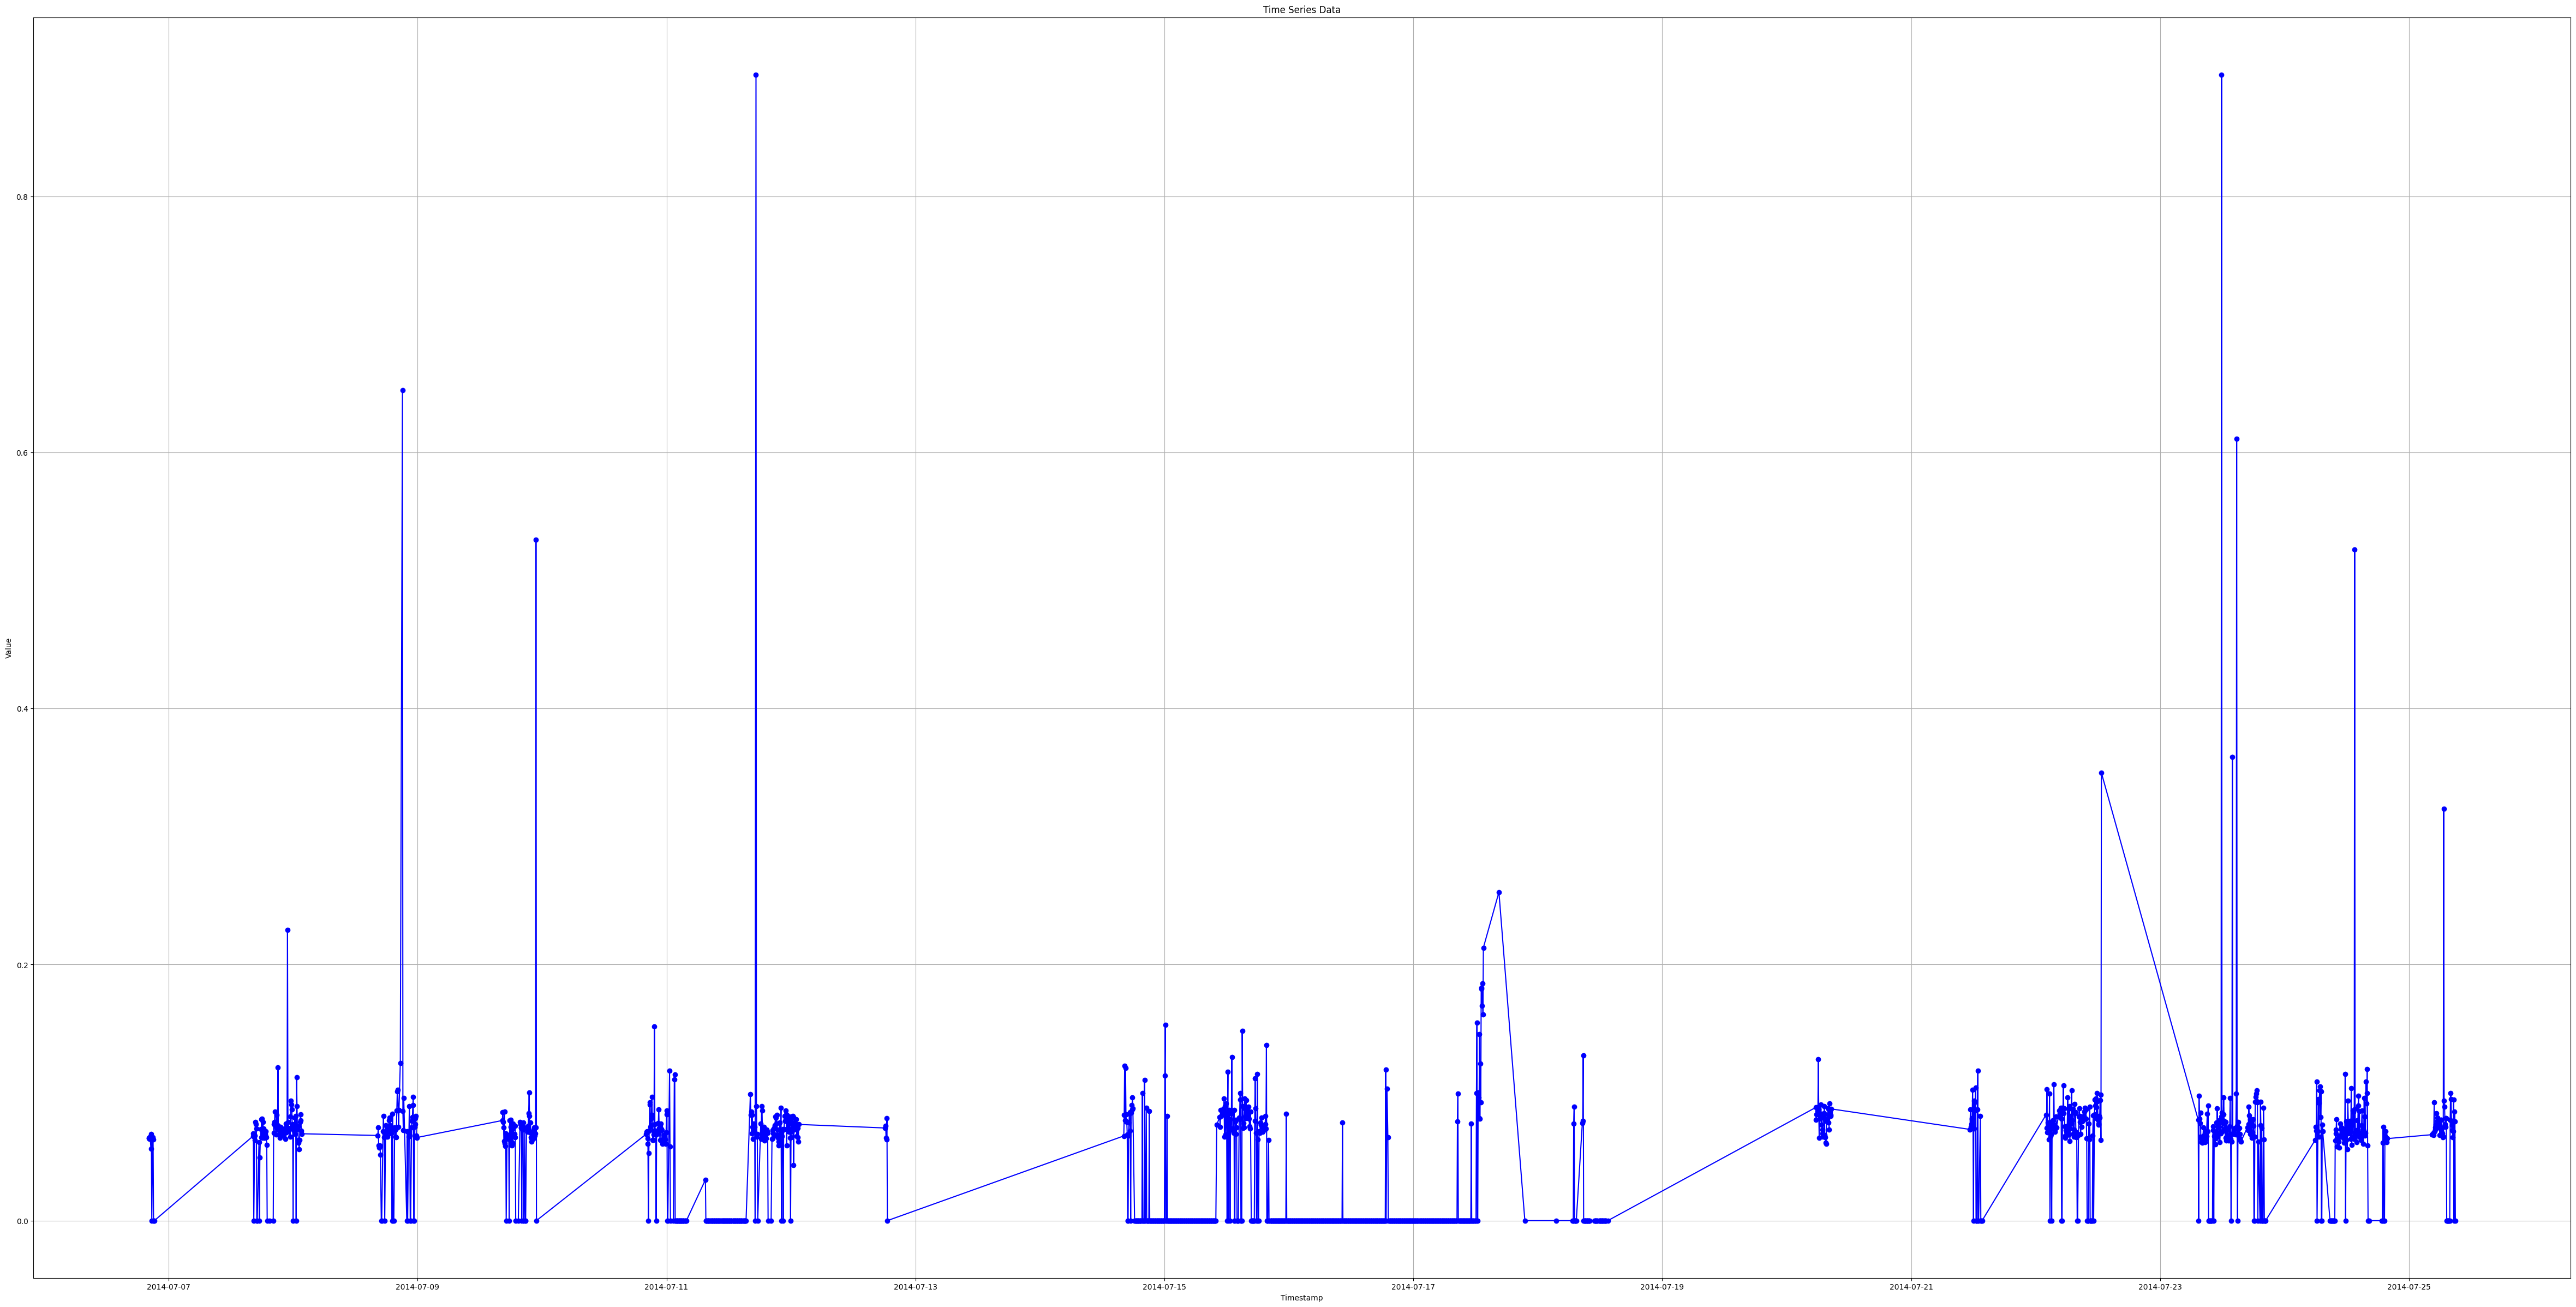

In [ ]:

# Visualize the first few rows of the dataset to identify the column names
print(data.head())

# If the timestamp column has a different name, replace 'timestamp' with the actual column name
# For example, if the timestamp column is named 'date_time', replace 'timestamp' with 'date_time'





# Plot the time series data
plt.figure(figsize=(60, 30))
plt.plot(data.index, data['value'], color='blue', marker='o', linestyle='-')
plt.title('Time Series Data')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [ ]:

# Display summary statistics
summary_stats = data.describe()
print(summary_stats)

             value
count  1882.000000
mean      0.039578
std       0.056545
min       0.000000
25%       0.000000
50%       0.000000
75%       0.072769
max       0.895012


In [ ]:
# Convert timestamp column to datetime format
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Set timestamp column as the index
data.set_index('timestamp', inplace=True)

# Resample the data into 15-minute intervals and aggregate using mean
segmented_data = data.resample('15T').mean()

# Print the segmented data
print(segmented_data)

                        value
timestamp                    
2014-07-06 20:00:00  0.064535
2014-07-06 20:15:00  0.064622
2014-07-06 20:30:00  0.062026
2014-07-06 20:45:00  0.032644
2014-07-06 21:00:00  0.021060
...                       ...
2014-07-25 07:45:00  0.026279
2014-07-25 08:00:00  0.090752
2014-07-25 08:15:00  0.070121
2014-07-25 08:30:00  0.054780
2014-07-25 08:45:00  0.054243

[1780 rows x 1 columns]


<ipython-input-16-360bb86dfb5e>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  segmented_data = data.resample('15T').mean()


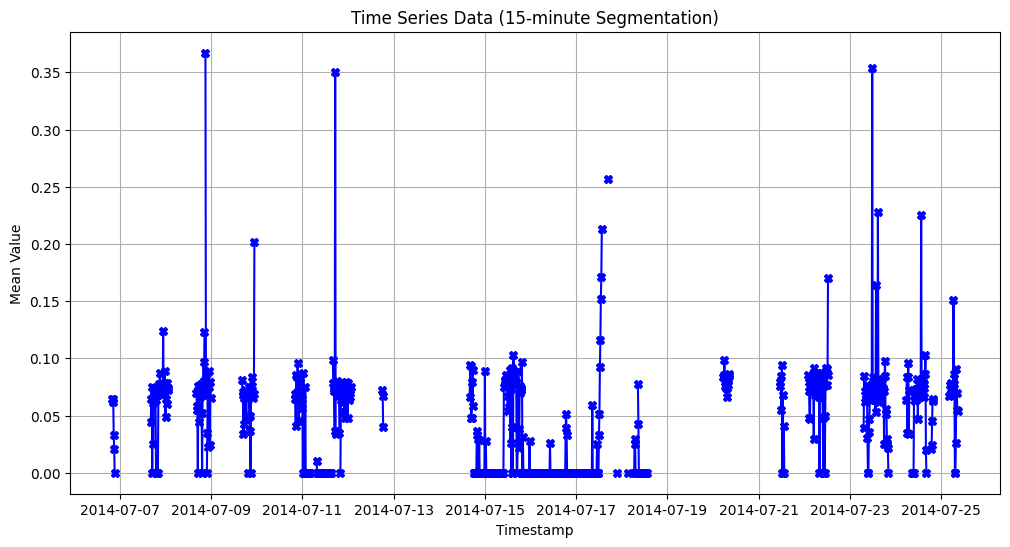

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Plot the segmented data
plt.figure(figsize=(12, 6))
plt.plot(segmented_data.index, segmented_data['value'], color='blue', marker='X', linestyle='-')
plt.title('Time Series Data (15-minute Segmentation)')
plt.xlabel('Timestamp')
plt.ylabel('Mean Value')
plt.grid(True)
plt.show()


<Figure size 1200x600 with 0 Axes>

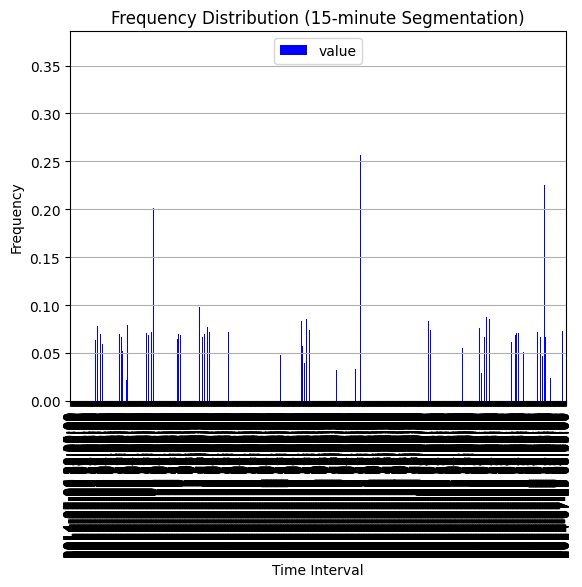

In [ ]:

# Plot the frequency distribution
plt.figure(figsize=(12, 6))
segmented_data.plot(kind='bar', color='blue')
plt.title('Frequency Distribution (15-minute Segmentation)')
plt.xlabel('Time Interval')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

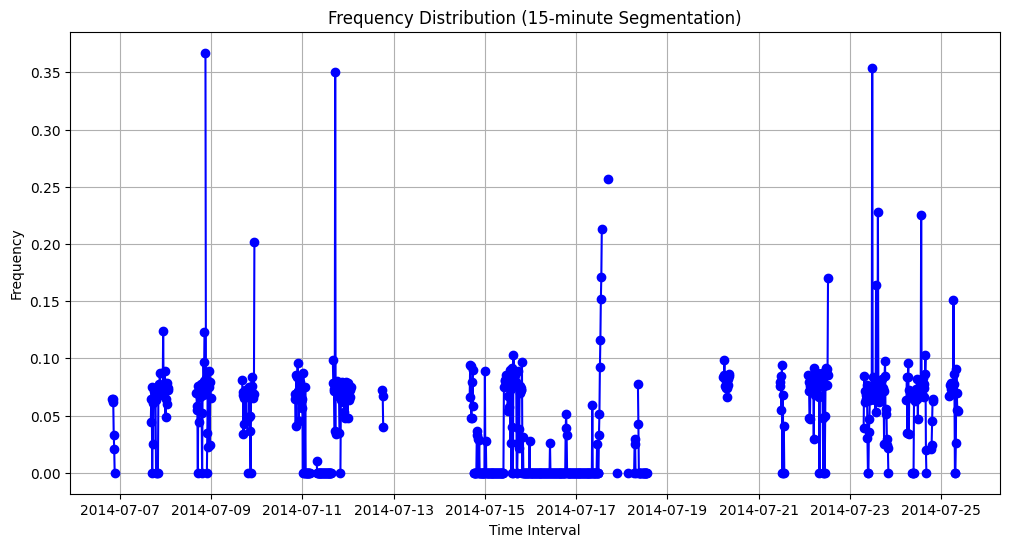

In [ ]:

# Plot the frequency distribution using a line plot
plt.figure(figsize=(12, 6))
plt.plot(segmented_data.index, segmented_data.values, color='blue', marker='o', linestyle='-')
plt.title('Frequency Distribution (15-minute Segmentation)')
plt.xlabel('Time Interval')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

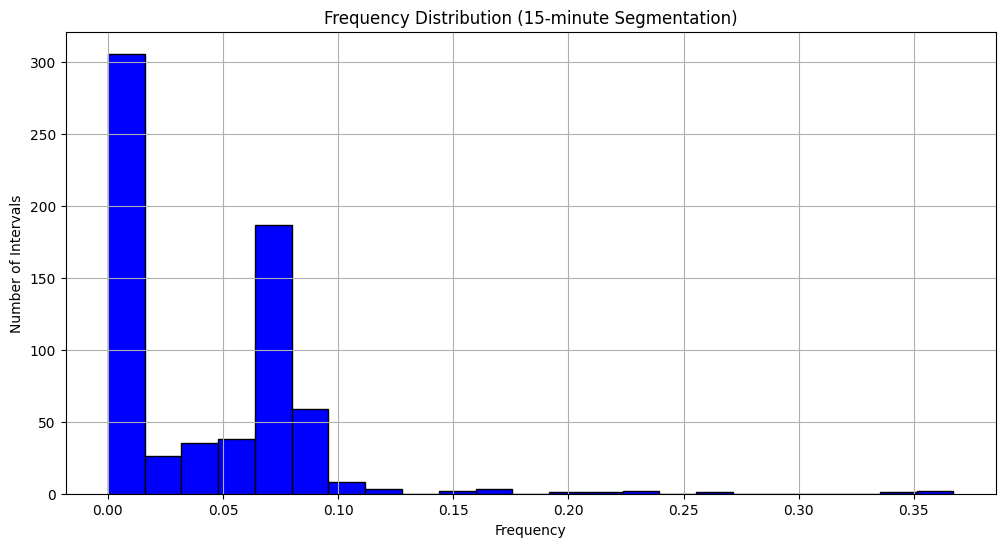

In [ ]:
# Plot the frequency distribution using a histogram
plt.figure(figsize=(12, 6))
plt.hist(segmented_data, bins='auto', color='blue', edgecolor='black')
plt.title('Frequency Distribution (15-minute Segmentation)')
plt.xlabel('Frequency')
plt.ylabel('Number of Intervals')
plt.grid(True)
plt.show()

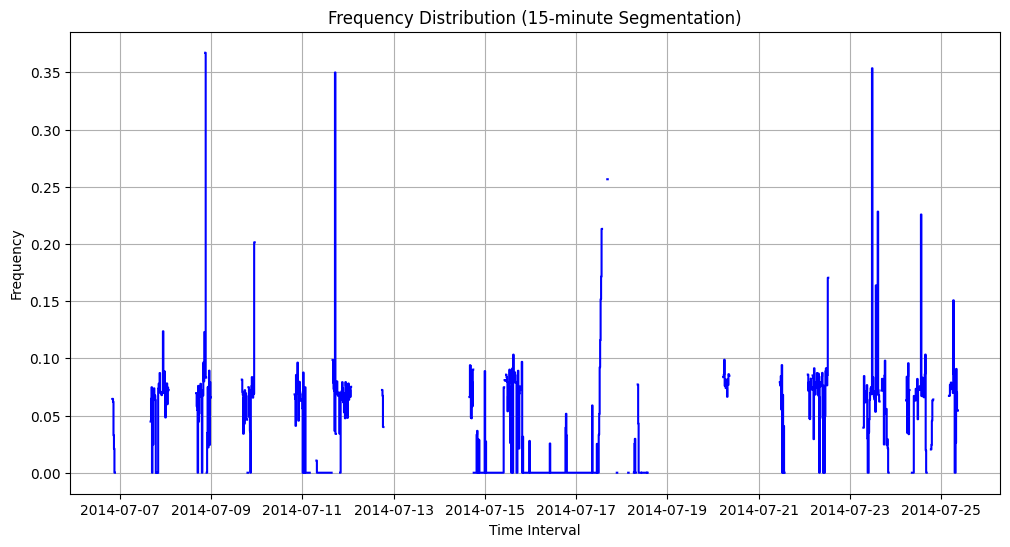

In [ ]:
# Plot the frequency distribution using a step plot
plt.figure(figsize=(12, 6))
plt.step(segmented_data.index, segmented_data.values, where='mid', color='blue')
plt.title('Frequency Distribution (15-minute Segmentation)')
plt.xlabel('Time Interval')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:


# Calculate Z-scores for the 'value' column
data['z_score'] = (data['value'] - data['value'].mean()) / data['value'].std()

# Define a threshold for identifying outliers (e.g., Z-score > 3 or Z-score < -3)
threshold = 3

# Segment the data into normal and outlier observations
normal_data = data[data['z_score'] <= threshold]
outlier_data = data[data['z_score'] > threshold]

# Print the number of normal and outlier observations
print("Number of normal observations:", len(normal_data))
print("Number of outlier observations:", len(outlier_data))

# Perform further analysis on each segment as needed


Number of normal observations: 1870
Number of outlier observations: 12


In [ ]:
import numpy as np

def time_series_segmentation(time_series, hw, num_features):
    """
    Segment the time series into overlapping history and prediction windows.

    Args:
    - time_series: numpy array representing the time series data, shape (t, m)
    - hw: integer, size of the history window
    - num_features: integer, number of features in the time series

    Returns:
    - history_windows: list of numpy arrays, each representing a history window, shape (hw, num_features)
    - prediction_windows: list of numpy arrays, each representing a prediction window, shape (1, num_features)
    """
    t = len(time_series)
    history_windows = []
    prediction_windows = []

    for i in range(t - hw):
        # Extract history window
        history_window = time_series[i:i + hw]

        # Extract prediction window
        prediction_window = time_series[i + hw:i + hw + 1]

        # Append to lists
        history_windows.append(history_window)
        prediction_windows.append(prediction_window)

    return history_windows, prediction_windows

def min_max_normalization(data):
    """
    Perform min-max normalization on the input data.

    Args:
    - data: numpy array to be normalized

    Returns:
    - normalized_data: numpy array, normalized data
    """
    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data


In [ ]:
def time_series_segmentation(data, history_window_size, prediction_window_size):
    """
    Segment time-series data into overlapping history and prediction windows.

    Parameters:
    - data: The multivariate time-series data (2D array or DataFrame).
    - history_window_size: The size of the history window (int).
    - prediction_window_size: The size of the prediction window (int).

    Returns:
    - history_windows: List of history windows.
    - prediction_windows: List of prediction windows.
    """
    history_windows = []
    prediction_windows = []

    # Apply sliding window approach
    for i in range(len(data) - history_window_size - prediction_window_size + 1):
        history_window = data[i:i + history_window_size]
        prediction_window = data[i + history_window_size:i + history_window_size + prediction_window_size]

        history_windows.append(history_window)
        prediction_windows.append(prediction_window)

    return history_windows, prediction_windows


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

def quantile_loss(y_true, y_pred, quantile):
    """
    Custom quantile loss function for training the LSTM model.

    Parameters:
    - y_true: True target values.
    - y_pred: Predicted target values.
    - quantile: Desired quantile value (between 0 and 1).

    Returns:
    - Quantile loss.
    """
    error = y_true - y_pred
    return keras.backend.mean(keras.backend.maximum(quantile * error, (quantile - 1) * error), axis=-1)

def train_dqr_model(history_windows, prediction_windows, quantiles=[0.1, 0.5, 0.9], num_bootstrap=100):
    """
    Train the DQR model using LSTM-based RNNs.

    Parameters:
    - history_windows: List of history windows.
    - prediction_windows: List of prediction windows.
    - quantiles: List of desired quantiles (default: [0.1, 0.5, 0.9]).
    - num_bootstrap: Number of bootstrap iterations (default: 100).

    Returns:
    - Array of predicted quantiles.
    """
    # Prepare data for training
    X_train = np.array(history_windows)
    y_train = np.array(prediction_windows)

    # Define LSTM-based RNN model
    model = keras.Sequential([
        keras.layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
        keras.layers.Dense(len(quantiles), activation='linear')
    ])

    # Compile the model with custom quantile loss function
    model.compile(loss=lambda y_true, y_pred: quantile_loss(y_true, y_pred, quantiles[0]), optimizer='adam')

    # Train the model with bootstrapping
    predicted_quantiles = []
    for _ in range(num_bootstrap):
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
        predicted_quantiles.append(model.predict(X_train))

    return np.array(predicted_quantiles)

# Example usage
# history_windows and prediction_windows are obtained from the time_series_segmentation module
# predicted_quantiles = train_dqr_model(history_windows, prediction_windows)


In [ ]:
# Assuming 'data' is your multivariate time-series data (2D array or DataFrame)
# Specify the size of the history window and prediction window
history_window_size = 5
prediction_window_size = 1

# Perform time-series segmentation
history_windows, prediction_windows = time_series_segmentation(data, history_window_size, prediction_window_size)

# Display the segmented windows
print("History Windows:")
for window in history_windows:
    print(window)

print("\nPrediction Windows:")
for window in prediction_windows:
    print(window)
import matplotlib.pyplot as plt


Streaming output truncated to the last 5000 lines.
timestamp                                                 
2014-07-09 20:10:00  0.074126 2014-07-09 20:00:00  0.61098
                        value     hourly_interval   z_score
timestamp                                                  
2014-07-09 20:15:00  0.071203 2014-07-09 20:00:00  0.559292
                        value     hourly_interval   z_score
timestamp                                                  
2014-07-09 20:20:00  0.076607 2014-07-09 20:00:00  0.654862
                     value     hourly_interval   z_score
timestamp                                               
2014-07-09 20:25:00    0.0 2014-07-09 20:00:00 -0.699929
                     value     hourly_interval   z_score
timestamp                                               
2014-07-09 20:30:00    0.0 2014-07-09 20:00:00 -0.699929
                        value     hourly_interval   z_score
timestamp                                                  
2014-07-0

In [ ]:
# Define a threshold for anomaly detection scores
threshold = 0.5  # Adjust this threshold as needed

# Convert anomaly scores to binary labels based on the threshold
predicted_labels = [1 if score > threshold else 0 for score in anomaly_scores]

# Assuming you have true binary labels from labeled data
true_labels = [0, 0, 1, 0, 1, 1, 0, 0, 1, 1]  # Example true binary labels

# Calculate evaluation metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1-score: {f1}")


ValueError: Found input variables with inconsistent numbers of samples: [10, 90]

In [ ]:
# Check the lengths of the arrays
true_labels_length = len(true_labels)
predicted_labels_length = len(predicted_labels)

# If lengths don't match, truncate or pad the arrays accordingly
if true_labels_length != predicted_labels_length:
    # If true labels array is longer, truncate it
    if true_labels_length > predicted_labels_length:
        true_labels = true_labels[:predicted_labels_length]
    # If predicted labels array is longer, pad it
    else:
        # Pad the predicted labels array with appropriate values
        # For example, if padding with zeros:
        # predicted_labels = np.pad(predicted_labels, (0, true_labels_length - predicted_labels_length), mode='constant')
        pass  # Replace 'pass' with padding code

# Now both arrays have the same length, and you can proceed to calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Print or use the metrics as needed
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)


ValueError: Found input variables with inconsistent numbers of samples: [10, 90]

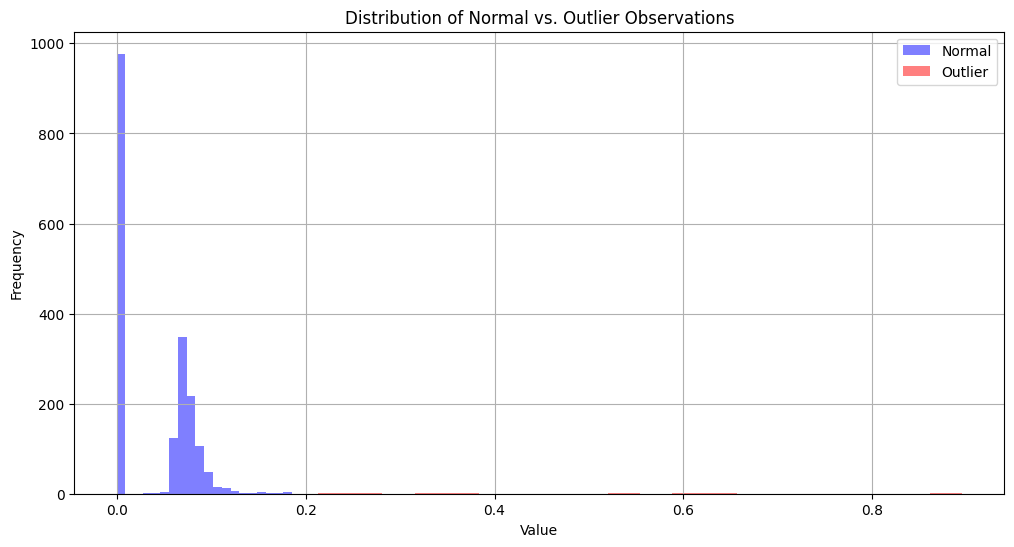

Summary Statistics for Normal Observations:
             value      z_score
count  1870.000000  1870.000000
mean      0.036711    -0.050692
std       0.039859     0.704908
min       0.000000    -0.699929
25%       0.000000    -0.699929
50%       0.000000    -0.699929
75%       0.072653     0.584933
max       0.185409     2.579023

Summary Statistics for Outlier Observations:
           value    z_score
count  12.000000  12.000000
mean    0.486254   7.899446
std     0.240314   4.249943
min     0.213153   3.069664
25%     0.305253   4.698443
50%     0.443119   7.136599
75%     0.620261  10.269334
max     0.895012  15.128296


KeyError: 'timestamp'

<Figure size 1200x600 with 0 Axes>

In [ ]:


# Visualize the distributions of normal and outlier observations
plt.figure(figsize=(12, 6))

# Histogram for normal observations
plt.hist(normal_data['value'], bins=20, alpha=0.5, color='blue', label='Normal')
# Histogram for outlier observations
plt.hist(outlier_data['value'], bins=20, alpha=0.5, color='red', label='Outlier')

plt.title('Distribution of Normal vs. Outlier Observations')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Compare summary statistics between normal and outlier observations
print("Summary Statistics for Normal Observations:")
print(normal_data.describe())
print("\nSummary Statistics for Outlier Observations:")
print(outlier_data.describe())

# Investigate temporal patterns or trends
plt.figure(figsize=(12, 6))

# Time series plot for normal observations
plt.plot(normal_data['timestamp'], normal_data['value'], color='blue', label='Normal')
# Time series plot for outlier observations
plt.plot(outlier_data['timestamp'], outlier_data['value'], color='red', label='Outlier')

plt.title('Temporal Patterns of Normal vs. Outlier Observations')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Explore potential factors contributing to outliers
# You may need additional information or variables to explore potential factors
# You can use scatter plots or correlation matrices for exploration
